# Confined Aquifer Test
**Extracted from Book K&dR**

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ttim import *

Set basic parameters for the model:

In [2]:
H = 7 #aquifer thickness
wt = -18 #top boundary of aquifer
wb = wt - H #bottom boundary of aquifer
Q = 788 #constant discharge

Create conceptual model:

In [3]:
#unkonwn parameters: kaq, Saq
ml = ModelMaq(kaq=60, z=[wt, wb], Saq=1e-4, tmin=1e-5, tmax=1)
w = Well(ml, xw=0, yw=0, rw=0.1, rc=0.2, tsandQ=[(0, Q)], layers=0)
ml.solve(silent='True')

Load data of two observation wells:

In [4]:
#time and drawdown of pizometer 30m away from pumping well
data1 = np.loadtxt('data/piezometer_h30.txt', skiprows = 1)
t1 = data1[:, 0] / 60 / 24 #convert min to days
h1 = data1[:, 1]
d1 = 30
#time and drawdown of piezometer 90m away from pumping well
data2 = np.loadtxt('data/piezometer_h90.txt', skiprows = 1)
t2 = data2[:, 0] / 60 / 24 #convert min to days
h2 = data2[:, 1]
d2 = 90

Calibrate model with two datasets simultaneously:

In [5]:
ca = Calibrate(ml)
ca.set_parameter(name='kaq0', initial=10)
ca.set_parameter(name='Saq0', initial=1e-4)
ca.set_parameter_by_reference(name='rc', parameter=w.rc[:], initial=0.5, pmin=0.01)
ca.series(name='obs1', x=d1, y=0, t=t1, h=h1, layer=0)
ca.series(name='obs2', x=d2, y=0, t=t2, h=h2, layer=0)
ca.fit(report=True)
display(ca.parameters)

....................................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 65
    # data points      = 69
    # variables        = 3
    chi-square         = 0.17295405
    reduced chi-square = 0.00262052
    Akaike info crit   = -407.229672
    Bayesian info crit = -400.527353
[[Variables]]
    kaq0:  66.0942055 +/- 1.69346678 (2.56%) (init = 10)
    Saq0:  2.5397e-05 +/- 2.4382e-06 (9.60%) (init = 0.0001)
    rc:    0.01000063 +/- 0.00318834 (31.88%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.857
    C(kaq0, rc)   =  0.174
    C(Saq0, rc)   = -0.124


,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,66.0942,1.693467,2.5622,-inf,inf,10,[66.09420548098683]
Saq0,2.53974e-05,0.000002,9.60001,-inf,inf,0.0001,[2.5397425346160583e-05]
rc,0.0100006,0.003188,31.8814,0.01,inf,0.5,[0.010000634011849474]


rmse: 0.05006576107067656


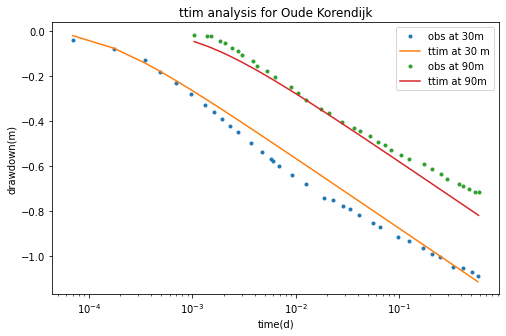

In [6]:
print('rmse:', ca.rmse())
hm1 = ml.head(d1, 0, t1)
hm2 = ml.head(d2, 0 ,t2)
plt.figure(figsize = (8, 5))
plt.semilogx(t1, h1, '.', label='obs at 30m')
plt.semilogx(t1, hm1[0], label='ttim at 30 m')
plt.semilogx(t2, h2, '.', label='obs at 90m')
plt.semilogx(t2, hm2[0], label = 'ttim at 90m')
plt.xlabel('time(d)')
plt.ylabel('drawdown(m)')
plt.title('ttim analysis for Oude Korendijk')
plt.legend();

#### Theis's method

In [7]:
from scipy import integrate
from lmfit import Parameters, minimize, fit_report

Create Headfunction of Theis's method:

In [8]:
def F(x):
    return np.exp(-x)/x

def Headfunc(r, t0, t, Q, k, H, S):
    T = k * H
    a = len(t)
    h = [None] * a
    for i in range(len(t)):
        u = r ** 2 * S / (4 * T * (t[i] - t0))
        E, err = integrate.quad(F, u, np.inf)
        h[i] = - Q * E / (4 * np.pi * T)
    return h

Define calibrate function:

In [9]:
def lmT(p, dat1 = None, dat2 = None, result = 0):
    t1 = dat1[:, 0] / 60 / 24
    t2 = dat2[:, 0] / 60 / 24
    h1 = dat1[:, 1]
    h2 = dat2[:, 1]
    vals = p.valuesdict()
    kaq = vals['kaq']
    Saq = vals['Saq']
    d1 = vals['d1']
    d2 = vals['d2']
    
    hm1 = Headfunc(d1, 0, t1, 788, kaq, 7, Saq)
    hm2 = Headfunc(d2, 0, t2, 788, kaq, 7, Saq)
    
    resid1 = h1 - hm1
    resid2 = h2 - hm2
    if result == 0:
        return np.concatenate((resid1, resid2))
    else:
        return hm1, hm2

In [10]:
PH = Parameters()
PH.add('kaq', value = 100)
PH.add('Saq', value = 1e-4)
PH.add('d1', value = 30)
PH.add('d2', value = 90)
PH['d1'].vary = False
PH['d2'].vary = False

Calibrate with two datasets simultneously:

In [11]:
resultH = minimize(lmT, PH, kws = {'dat1':data1, 'dat2':data2}, epsfcn=1e-8, xtol=1e-5)
print(fit_report(resultH))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 69
    # variables        = 2
    chi-square         = 0.17291621
    reduced chi-square = 0.00258084
    Akaike info crit   = -409.244768
    Bayesian info crit = -404.776555
[[Variables]]
    kaq:  66.0881654 +/- 1.63797049 (2.48%) (init = 100)
    Saq:  1.7788e-04 +/- 1.6700e-05 (9.39%) (init = 0.0001)
    d1:   30 (fixed)
    d2:   90 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq, Saq) = -0.855


In [12]:
hH1, hH2 = lmT(resultH.params, dat1 = data1, dat2 = data2, result = 1)
ht = np.append(h1, h2)
htH = np.append(hH1, hH2)
r = [0] * len(ht) 
x = 0
for i in range(len(r)):
    r[i] = (ht[i] - htH[i]) ** 2
    x += r[i]
rmse = np.sqrt(x) / len(ht)
print('rmse:', rmse)

rmse: 0.006026550071888317


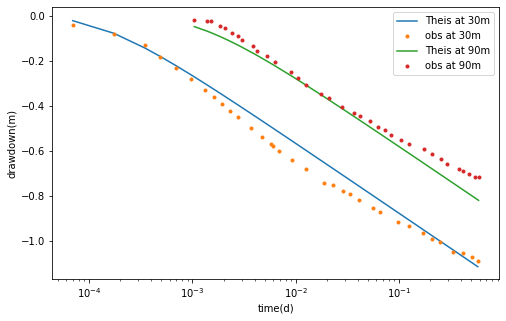

In [13]:
hH1, hH2 = lmT(resultH.params, dat1=data1, dat2=data2, result=1)
plt.figure(figsize=(8, 5))
plt.semilogx(t1, hH1, label='Theis at 30m')
plt.semilogx(t1, h1, '.', label='obs at 30m')
plt.semilogx(t2, hH2, label='Theis at 90m')
plt.semilogx(t2, h2, '.', label='obs at 90m')
plt.xlabel('time(d)')
plt.ylabel('drawdown(m)')
plt.legend();

#### Thiem's method

Calculate hydraulic conductivity with Thiem's method:

In [14]:
s2 = h2[-1]
s1 = h1[-1]

T = 788 * 2.30 * np.log10(d2 / d1) / (2 * np.pi * (s2 - s1))
k = T / 7
print(k)

52.8520660573295
